In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import warnings
warnings.filterwarnings('ignore')

In [27]:

dir_path = "/Users/test/Downloads/archive/img_align_celeba/img_align_celeba"

from os import listdir
from os.path import isfile, join

def load_images(folder_path, img_size = (128, 128)):
    X = []
    limit = 5000
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array, img_size)
        img_array = img_array[:,:,::-1]
        X.append(img_array / 255.0)
        if len(X) >= limit:
            break
    return np.array(X)

img_size = 64
X_train = load_images(dir_path, (img_size, img_size))
X_train.shape

  2%|▏         | 4999/202599 [00:02<01:54, 1723.32it/s]


(5000, 64, 64, 3)

In [28]:
class GAN(Model):
    def __init__(self, Generator, Discriminator):
        super().__init__()
        self.latent_dim = 128
        self.generator = Generator
        self.discriminator = Discriminator
        # print(self.generator.model.summary())
    def compile(self, gen_optimizer, disc_optimizer, criterion):
        super().compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss


    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def train_step(self, images):
        
        noise = tf.random.normal([images.shape[0], self.latent_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}

In [29]:
fixed_noise = tf.random.normal((60, 128))

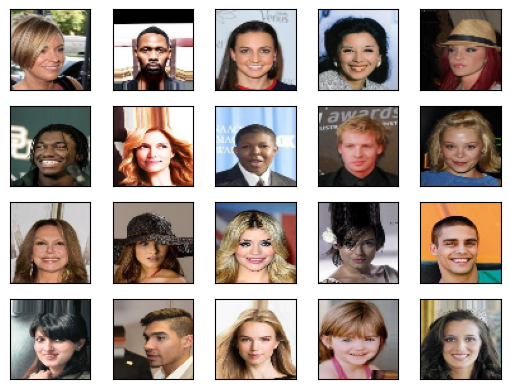

In [30]:
def show_images(images):
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
show_images(X_train)

In [19]:
Discriminator = Sequential([
    layers.Conv2D(256, kernel_size = (3, 3), strides = 2, padding = 'same', input_shape = (64, 64, 3)),
    layers.LeakyReLU(),

    layers.Conv2D(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Conv2D(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(1)
])

In [31]:
Generator = Sequential([
    layers.Dense(8 * 8 * 128, input_shape = (128,)),
    layers.BatchNormalization(),

    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(256, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Conv2DTranspose(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),


    layers.Conv2DTranspose(3, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'sigmoid'),
])

In [32]:
model = GAN(Generator, Discriminator)
model.compile(gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              criterion = tf.keras.losses.BinaryCrossentropy(True))

In [33]:
model.fit(X_train, epochs = 10, batch_size = 10)

Epoch 1/10
500/500 [==============================] - 55s 109ms/step - Generator Loss: 11.1579 - Discriminator Loss: 0.0125
Epoch 2/10
500/500 [==============================] - 62s 124ms/step - Generator Loss: 7.4311 - Discriminator Loss: 0.0329
Epoch 3/10
500/500 [==============================] - 65s 130ms/step - Generator Loss: 8.4906 - Discriminator Loss: 0.0294
Epoch 4/10
500/500 [==============================] - 66s 132ms/step - Generator Loss: 7.4081 - Discriminator Loss: 0.0316
Epoch 5/10
500/500 [==============================] - 64s 128ms/step - Generator Loss: 7.8026 - Discriminator Loss: 0.0616
Epoch 6/10
500/500 [==============================] - 64s 128ms/step - Generator Loss: 6.9912 - Discriminator Loss: 0.0625
Epoch 7/10
500/500 [==============================] - 65s 130ms/step - Generator Loss: 6.7953 - Discriminator Loss: 0.0371
Epoch 8/10
500/500 [==============================] - 67s 135ms/step - Generator Loss: 6.4252 - Discriminator Loss: 0.0814
Epoch 9/10
500/

2/2 [==============================] - 0s 83ms/step


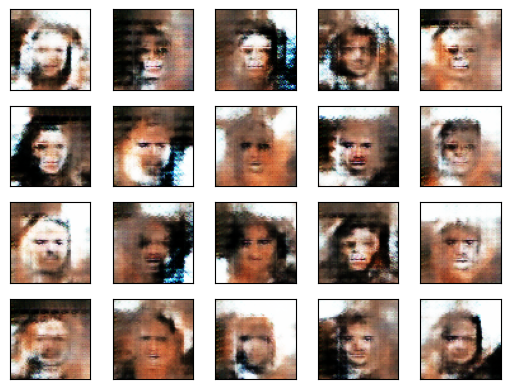

In [34]:
y_pred = model.generator.predict(fixed_noise)
show_images(y_pred)